In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch

from gptopt.optim.pdhg import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$


## FISTA for dual solve

$$
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array}  
$$
recover primal using
$$
Z = -\frac{1}{\mu}(\mathcal{A}^*(Y) + G)
$$

In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 200

mu_scale = 0.1

#  $m=n=50$

In [4]:
m = n = 50
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)
beta = 0.001

mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
mu_reg = max(mu_scale * mu_max, 1e-6)
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5

print(f"{mu_reg=:.4e}, {lamb_max=:.4e}, {mu_max=:.4e}")

A.shape=torch.Size([50, 50]), rank_tol=5.0000e+01, sigma_max=9.6652e-02, fro_norm=3.4762e-01
A.shape=torch.Size([50, 50]), rank_tol=5.0000e+01, sigma_max=9.8498e-02, fro_norm=3.5688e-01
A.shape=torch.Size([50, 50]), rank_tol=3.5000e+01, sigma_max=4.9658e-03, fro_norm=1.2603e-02
A.shape=torch.Size([50, 50]), rank_tol=3.5000e+01, sigma_max=4.4633e-03, fro_norm=1.2492e-02
mu_reg=6.2246e-03, lamb_max=4.9820e-01, mu_max=6.2246e-02


In [5]:
Z_star_1, Z_star_2, f_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg, verbose=False)

In [6]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [7]:
func_obj = lambda Z1, Z2: (torch.trace(G1.T @ Z1) + torch.trace(G2.T @ Z2) \
                          + (mu_reg / 2) * ((Z1).pow(2).sum() + Z2.pow(2).sum())).item()  
func_constr_viol = lambda Z1, Z2: max(torch.max(torch.abs(Z1.T @ B + A.T @ Z2)).item() - beta, 0) / beta

In [8]:
print(
    f"{f_star=}, "
    f"{func_obj(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}"
)

f_star=np.float64(-0.01928268828365131), -0.019282687455415726, 
cvxpy constraint violation: 5.13158738592312e-07


In [9]:
residuals = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=f_star, 
                            stopping=False, max_iter=max_iter, pd_residuals=pd_residuals_infty_ball)

lamb_max=0.49819795677752865
obj (diag scaling):  -0.01927933283150196 
constraint viol (diag scaling):  0.009642845019698122
lamb_max=0.49819795677752865
obj (vanilla):  -0.019182000309228897 
constraint viol (vanilla):  0.036871690303087214
lamb_max=0.49819795677752865
obj (acceleration):  -0.018121857196092606 
constraint viol (acceleration):  0.027298858389258364
obj (fista):  -0.01928146928548813 
constraint viol (fista):  0.017899834550917128


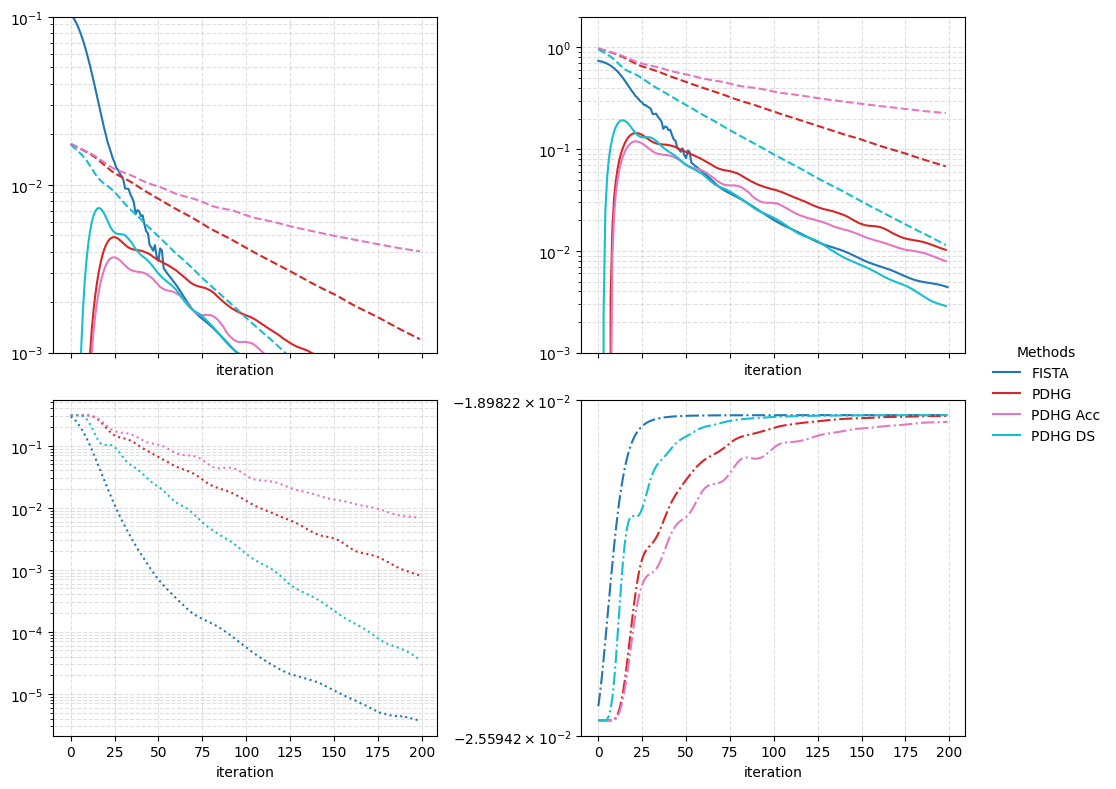

In [15]:
plot_residuals_compare(residuals, dpi=100, dual_scale=True,
                       abs_ylim=(1e-3, 1e-1), rel_ylim=(1e-3, 2))

#  $m=n=1000$

In [16]:
m = n = 1000
std2 = 1 
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)
beta = 0.001

mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
mu_reg = max(mu_scale * mu_max, 1e-6)
lamb_max = (A.pow(2).sum().sqrt().item() + B.pow(2).sum().sqrt().item()) ** 0.5

print(f"{mu_reg=:.4e}, {lamb_max=:.4e}, {mu_max=:.4e}")

A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4863e-01, fro_norm=7.0727e+00
A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4739e-01, fro_norm=7.0797e+00
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=1.1590e-01, fro_norm=1.2544e+00
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=1.1679e-01, fro_norm=1.2537e+00
mu_reg=1.9129e-01, lamb_max=3.7620e+00, mu_max=1.9129e+00


In [17]:
residuals = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, pd_residuals=pd_residuals_infty_ball)

lamb_max=10.00730746586136


obj (diag scaling):  -6.730257034301758 
constraint viol (diag scaling):  0.20160623919218776
lamb_max=10.00730746586136
obj (vanilla):  -6.647101879119873 
constraint viol (vanilla):  0.5014610253274441
lamb_max=10.00730746586136
obj (acceleration):  -6.407195091247559 
constraint viol (acceleration):  0.5002974541857839
obj (fista):  -6.723422527313232 
constraint viol (fista):  0.0667768074199557


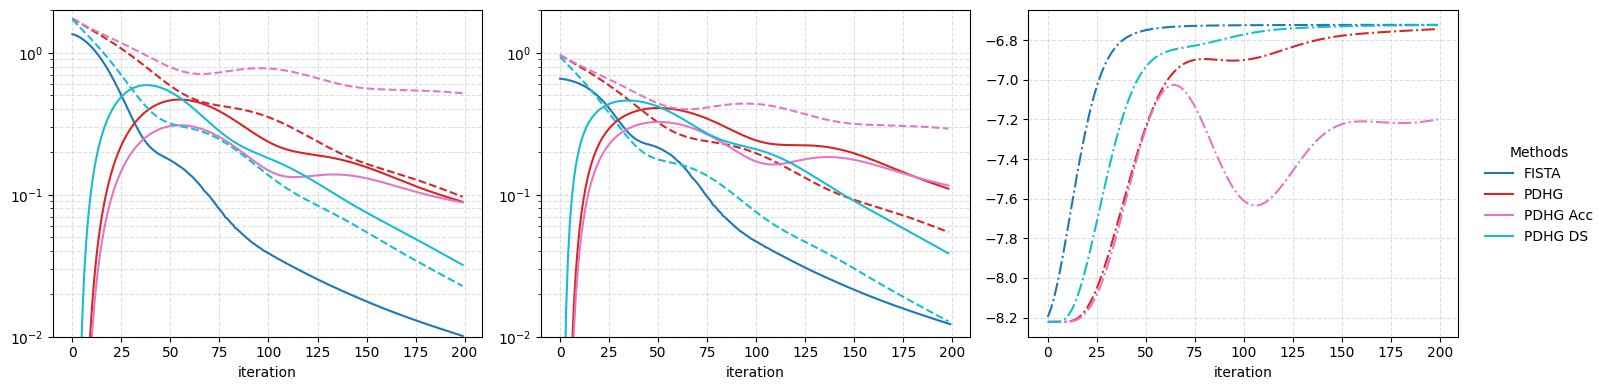

In [22]:
plot_residuals_compare(residuals, abs_ylim=(1e-2, 2), rel_ylim=(1e-2, 2), dpi=100)

#  $m=n=1000$

In [23]:
m = n = 1000
std2 = 0.1
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)
beta = 0.001

mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
mu_reg = max(mu_scale * mu_max, 1e-6)
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}, {mu_max=:.4e}")

A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4555e-01, fro_norm=7.0724e+00
A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4544e-01, fro_norm=7.0723e+00
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=1.1773e-02, fro_norm=1.2536e-01
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=1.1700e-02, fro_norm=1.2539e-01
mu_reg=1.9918e-02, lamb_max=1.0002e+01, mu_max=1.9918e-01


In [24]:
residuals = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            max_iter=max_iter, stopping=False, pd_residuals=pd_residuals_infty_ball)

lamb_max=10.001801860030563
obj (diag scaling):  -0.525213360786438 
constraint viol (diag scaling):  0.3264804147183895
lamb_max=10.001801860030563
obj (vanilla):  -0.4152788519859314 
constraint viol (vanilla):  0.3188176089897752
lamb_max=10.001801860030563
obj (acceleration):  -0.37531813979148865 
constraint viol (acceleration):  0.2376485392451286
obj (fista):  -0.6447415351867676 
constraint viol (fista):  0.4035006752237677


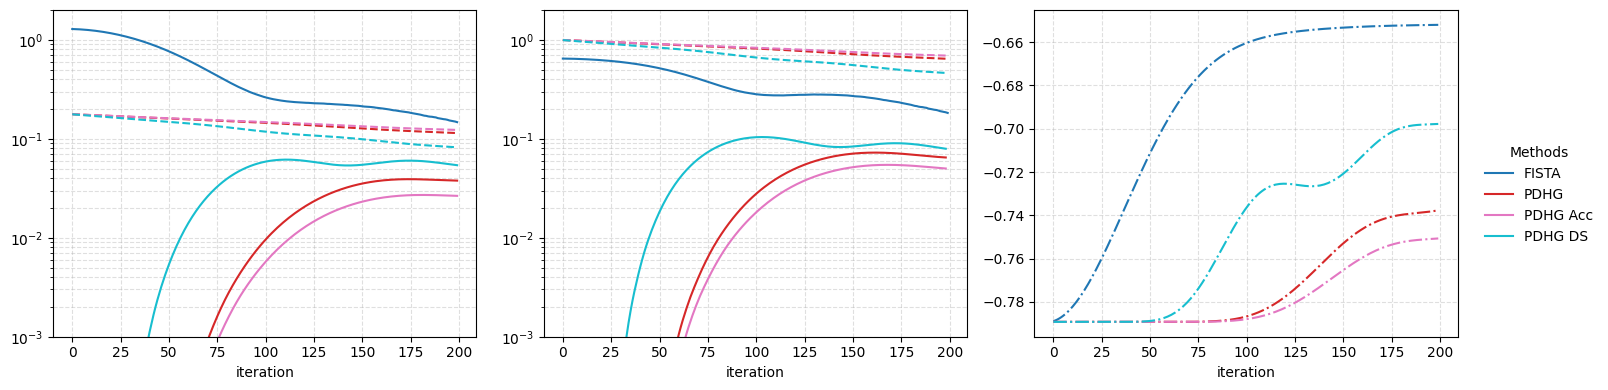

In [28]:
plot_residuals_compare(residuals, abs_ylim=(1e-3, 2), rel_ylim=(1e-3, 2), dpi=100)